In [1]:
%matplotlib inline

from imports import *
from matplotlib.patches import ConnectionPatch
from sklearn.preprocessing import normalize
from scipy.stats.stats import pearsonr, spearmanr
from correlation import cluster_corr
from scipy.cluster.hierarchy import dendrogram

import itertools
np.set_printoptions(suppress=True)

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [9]:
s1 = "008229_hippoSIT_2022-05-17_21-44-43"
units_all = {
    1: [2, 4, 8, 10, 15, 18, 19, 22, 26, 28],
    3: [3, 8, 12, 13, 14],
    4: [2, 4, 8, 16],
    5: [7, 14, 15, 16, 18, 20, 25, 28, 29, 31],
    6: [2, 4, 5, 7, 18, 19, 20, 21],
    7: [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19],
    8: [2, 3, 4, 5, 8, 10, 11, 12, 13, 15, 16, 17],
}

# s2 = "008229_hippoSIT_2022-05-16_20-36-44"
# units_all = {
#     1: [7, 8, 10, 23, 24, 33, 36, 37, 38],
#     2: [9, 15],
#     5: [13],
#     6: [5, 10, 18, 23, 25, 26],
#     7: [2, 3, 4, 5, 6, 7, 9, 12, 14, 15, 17, 18],
#     8: [3, 5, 6, 9, 12, 13, 14, 15, 16, 17, 18, 19],
# }

# s3 = "008229_hippoSIT_2022-05-20_15-54-39"
# units_all = {
#     1: [10, 13, 15],
#     2: [4, 6, 8, 9, 10, 11],
#     3: [3, 5, 8, 11, 13, 14, 15, 17, 18, 19, 20, 21],
#     4: [3, 5, 8, 12, 13, 14],
#     5: [5, 6],
#     6: [3, 5, 7, 8, 9, 11, 14],  # 7, 11 - food
#     7: [2, 3, 4, 7, 8, 9],
#     8: [3, 7, 11, 12],
# }

# s4 = "009266_hippoSIT_2023-04-24_16-56-55"
# units_all = {
#     1: list(np.arange(18) + 2),
#     2: [2],
#     3: list(np.arange(18) + 2),
#     4: [2, 3, 4, 5],
#     6: [2, 3, 4, 5, 6, 7, 8]
# }

# s4 = "008229_hippoSIT_2022-05-18_14-36-18"
# units_all = {
#     1: [2, 4, 12, 17, 18, 20, 24, 26],  # 16, 21 food
#     2: [2],
#     3: [2, 6, 7, 8],
#     4: [10, 13, 14, 15, 16, 17, 18, 19, 20, 21],
#     5: [2, 3, 5, 7, 8, 11, 15, 16, 18, 19, 20, 21, 22, 24, 25, 26, 27],
#     6: [2, 9, 14, 15, 16, 17, 18, 19, 20],
#     7: [3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16],  # could be spatial / ego
#     8: [2, 3, 4, 5, 6, 8, 10, 12, 13, 14, 15, 16, 17, 18],
# }

# s5 = "008229_hippoSIT_2022-05-31_11-00-02"
# units_all = {
#     1: [2, 3, 5, 6, 8, 9, 10, 11],  # 4 food
#     4: [3, 4, 5],  # 2 food
#     5: [5, 7, 8, 9, 11, 12, 13, 14, 15, 16],
#     7: [2, 3, 4, 5, 6],
#     8: [2, 3, 5, 6, 7, 8],
# }

# s6 = "008228_hippoSIT_2022-05-28_12-20-33"
# units_all = {
#     2: [2, 3, 4, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23],  # 5, 6 food
#     3: [2, 3, 5, 6, 8, 9, 10],
#     4: [2, 3, 4, 5],
#     5: [2, 4],
#     7: [2, 3, 5, 6, 7, 8],
#     8: [2, 3, 4, 5],
# }

# s7 = "008228_hippoSIT_2022-06-01_10-19-39"
# units_all = {
#     3: [2, 8, 9, 10, 12],
#     4: [2, 3, 4, 5, 6, 11, 12, 13, 14, 15, 16, 17],
#     5: [2],
#     7: [3, 4, 5, 6],  # 2 - food
#     8: [3, 4, 5, 8],
# }

units_list = []
for key, values in units_all.items():
    units_list = units_list + ['%s-%s' % (key, val) for val in values]

In [10]:
import functools
11/len(functools.reduce(lambda a, b: a+b, units_all.values()))

0.16666666666666666

In [11]:
source  = '/home/sobolev/nevermind/Andrey/data'
#source  = '/home/andrey/projects/data/'

session = s1

animal  = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
h5name  = os.path.join(source, animal, session, session + '.h5')

In [12]:
with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result
    
s_rate = 100 # Hz

## Speed correlations

In [14]:
with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.

width = 1000  # 100 points ~= 1 sec with at 100Hz
kernel = signal.gaussian(width, std=(width) / 7.2)
s_smooth = np.convolve(tl[:, 3], kernel, 'same') / kernel.sum()

speed_corrs = np.zeros((len(units_list), 2))  # corr coeff., p-value
for i, unit_name in enumerate(units_list):
    with h5py.File(h5name, 'r') as f:
        i_rate = np.array(f['units'][unit_name][H5NAMES.inst_rate['name']])
    
    speed_corrs[i] = pearsonr(i_rate, s_smooth)
    
unit_speed_sort_idxs = np.argsort(-speed_corrs[:, 0])

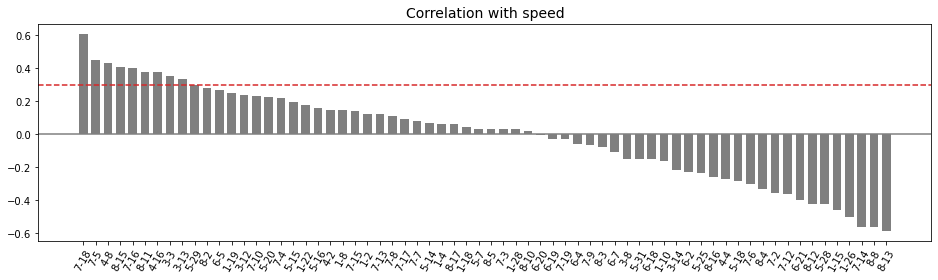

In [15]:
width = 0.7  # the width of the bars
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 1, 1)

ax.bar(range(len(speed_corrs)), speed_corrs[unit_speed_sort_idxs][:, 0], width, color=COLORS[4])
ax.axhline(0, color=COLORS[4])
ax.axhline(0.3, ls='--', color=COLORS[3])
ax.set_title('Correlation with speed', fontsize=14)
ax.set_xticks(range(len(speed_corrs)))
_ = ax.set_xticklabels(["%s" % units_list[j] for j in unit_speed_sort_idxs], rotation=60)

## Based on correlation matrix

In [16]:
#units_ccr = ['8-8', '5-28', '1-15', '1-2']
units_ccr = units_list

l = len(units_ccr)
corr_pearson, corr_spearman = np.zeros((l, l)), np.zeros((l, l))
for i, u1 in enumerate(units_ccr):
    for j, u2 in enumerate(units_ccr):
        with h5py.File(h5name, 'r') as f:
            i_rate1 = np.array(f['units'][u1][H5NAMES.inst_rate['name']])
            i_rate2 = np.array(f['units'][u2][H5NAMES.inst_rate['name']])

        if u1 == '7-18' and session == '008229_hippoSIT_2022-05-16_20-36-44':
            i_rate1[1930*s_rate:1950*s_rate] = 0
        if u2 == '7-18' and session == '008229_hippoSIT_2022-05-16_20-36-44':
            i_rate2[1930*s_rate:1950*s_rate] = 0
            
        corr_pearson[i, j]  = pearsonr(i_rate1, i_rate2)[0]
        #corr_spearman[i, j] = spearmanr(i_rate1, i_rate2)[0]

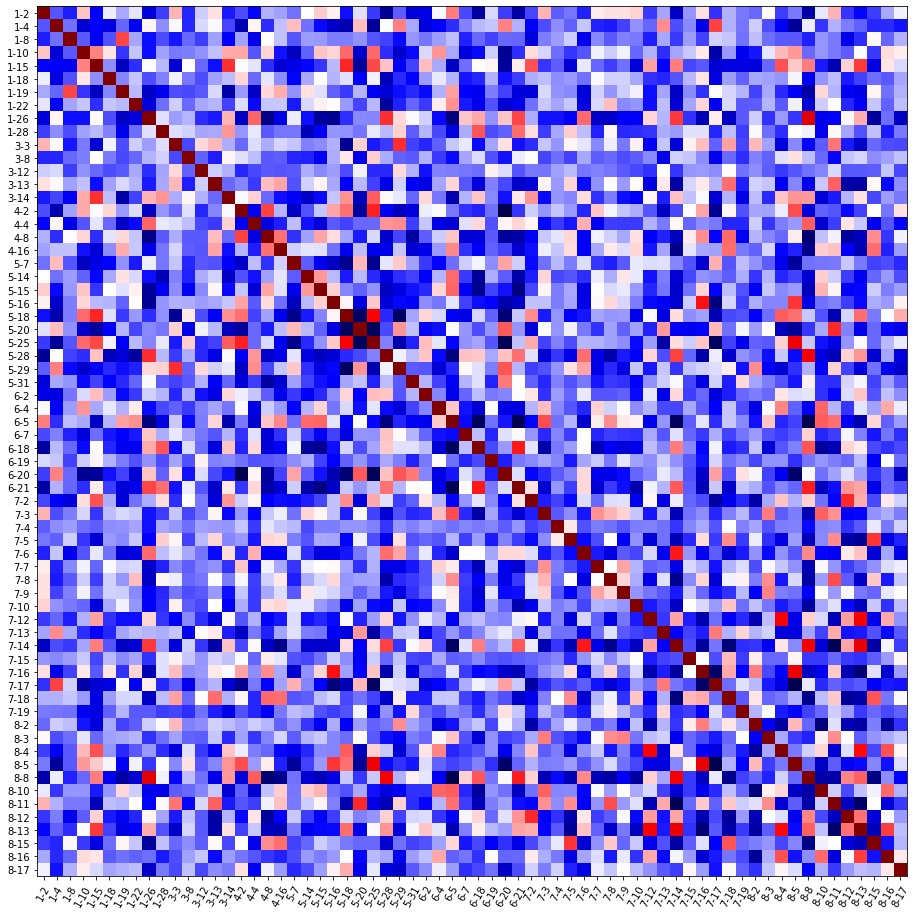

In [17]:
fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
ax.imshow(corr_pearson, cmap='seismic')
ax.set_xticks(range(corr_pearson.shape[0]))
ax.set_xticklabels(units_list, rotation=60)
ax.set_yticks(range(corr_pearson.shape[0]))
_ = ax.set_yticklabels(units_list)

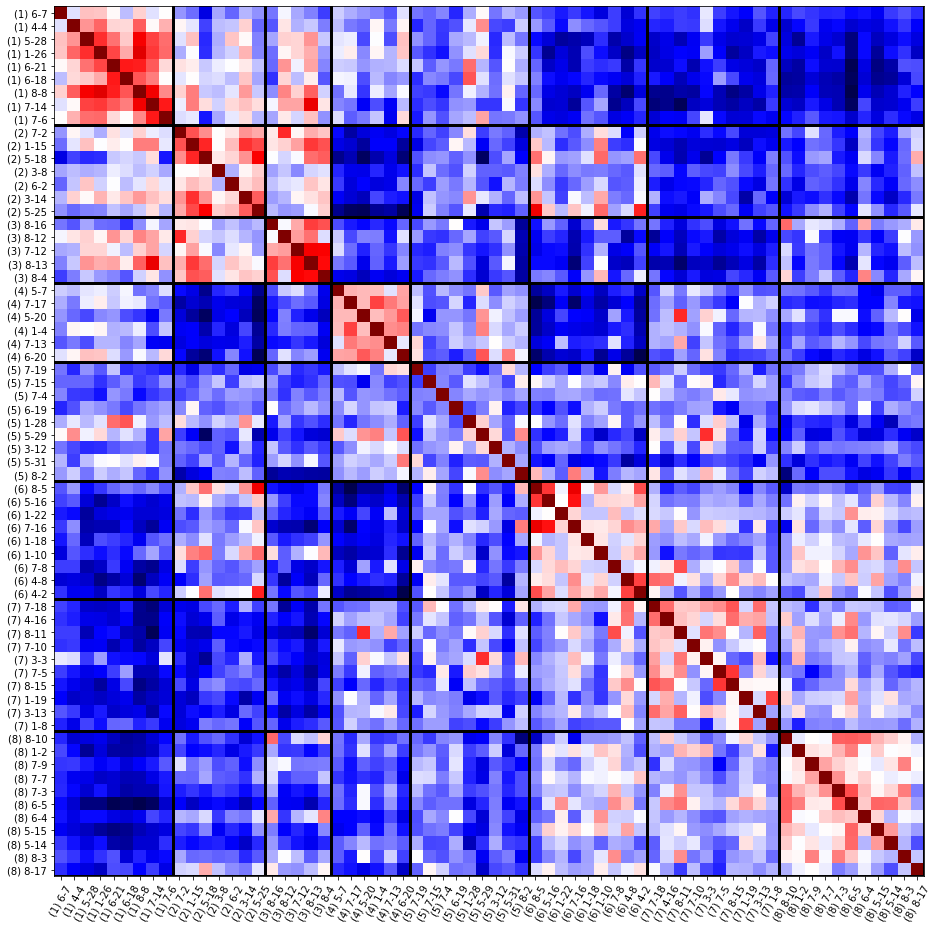

In [18]:
corr_srt, Z, labels, idxs_sort = cluster_corr(corr_pearson, threshold=2.6)

tick_labels = ["(%s) %s" % (labels[j], units_list[j]) for j in idxs_sort]

fig = plt.figure(figsize=(16, 16))
ax = fig.add_subplot(111)
ax.imshow(corr_srt, cmap='seismic')
ax.set_xticks(range(corr_srt.shape[0]))
ax.set_xticklabels(tick_labels, rotation=60)
ax.set_yticks(range(corr_srt.shape[0]))
_ = ax.set_yticklabels(tick_labels)
for clu_no in set(labels):
    l_pos = np.where(labels[idxs_sort] == clu_no)[0][-1] + 0.5
    ax.axhline(l_pos, color='black', lw=3)
    ax.axvline(l_pos, color='black', lw=3)

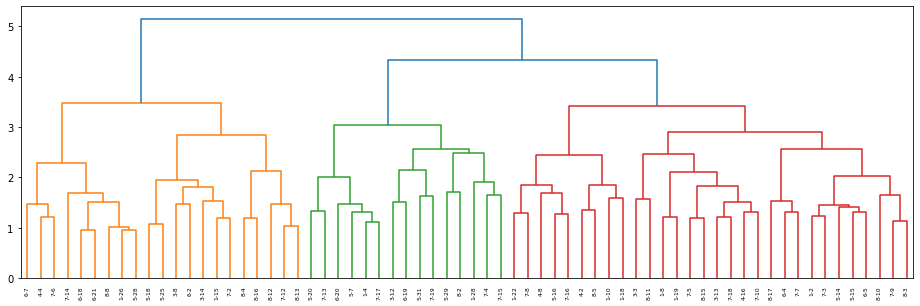

In [19]:
plt.figure(figsize=(16,5))
dendrogram(Z, labels=units_list, orientation='top', leaf_rotation=90);

## Covariance of correlation between states

In [983]:
#i_rate1 = instantaneous_rate(s_times1, tl[:, 0], k_width=200)
#i_rate2 = instantaneous_rate(s_times2, tl[:, 0], k_width=200)
    
#trials_only_idxs = np.where(tl[:, 5] > 0)
#no_pellet_search_idxs = 
#pearsonr(i_rate1, i_rate2), pearsonr(i_rate1[trials_only_idxs], i_rate2[trials_only_idxs])

In [83]:
source  = '/home/sobolev/nevermind/Andrey/data'
session = s4
unit_pairs = [
    ['8-18',  '8-16'],  # gree and blue, keep the order
]

animal  = session.split('_')[0]
sessionpath = os.path.join(source, animal, session)
h5name  = os.path.join(source, animal, session, session + '.h5')
with h5py.File(h5name, 'r') as f:
    tl = np.array(f['processed']['timeline'])  # time, X, Y, speed, etc.
    trials = np.array(f['processed']['trial_idxs'])  # t_start_idx, t_end_idx, x_tgt, y_tgt, r_tgt, result

trials_only_idxs = np.where(tl[:, 5] > 0)

collected = []
for pair in unit_pairs:
    with h5py.File(h5name, 'r') as f:
        #s_times1 = np.array(f['units'][pair[0]][H5NAMES.spike_times['name']])
        #s_times2 = np.array(f['units'][pair[1]][H5NAMES.spike_times['name']])
        i_rate1  = np.array(f['units'][pair[0]][H5NAMES.inst_rate['name']])
        i_rate2  = np.array(f['units'][pair[1]][H5NAMES.inst_rate['name']])

    i_corrs = np.zeros(240)
    for i in range(240):
        idx_l = (i*10)*s_rate
        idx_r = (i*10 + 120)*s_rate
        i_corrs[i] = pearsonr(i_rate1[idx_l:idx_r], i_rate2[idx_l:idx_r])[0]
        
    collected.append(i_corrs)

Text(0, 0.5, 'Corr. coeff.')

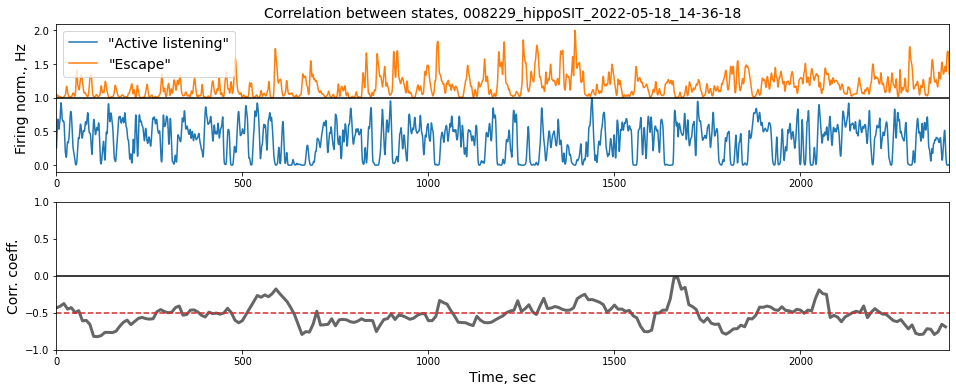

In [84]:
x_vals = tl[(10*np.arange(240)*s_rate).astype(np.int32)][:, 0]

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
for i, i_corrs in enumerate(collected):
    pair = unit_pairs[i]
    with h5py.File(h5name, 'r') as f:
        i_rate1  = np.array(f['units'][pair[0]][H5NAMES.inst_rate['name']])
        i_rate2  = np.array(f['units'][pair[1]][H5NAMES.inst_rate['name']])
    
    ax1.plot(tl[:, 0], i_rate1/i_rate1.max(), color=COLORS[0], label='"Active listening"')
    ax1.plot(tl[:, 0], i_rate2/i_rate2.max() + 1, color=COLORS[1], label='"Escape"')
    ax2.plot(x_vals, i_corrs, lw=3, color='black', alpha=0.6, label='Corr. coeff.')
    
ax1.set_xlim(0, 240*10)
ax1.axhline(1, color='black')
ax1.legend(fontsize=14, loc='upper left')
ax1.set_title('Correlation between states, %s' % session, fontsize=14)
ax1.set_ylabel('Firing norm., Hz', fontsize=14)
ax2.axhline(0, color='black')
ax2.set_xlim(0, 240*10)
ax2.set_ylim(-1, 1)
ax2.axhline(-0.5, ls='--', color=COLORS[3])
ax2.set_xlabel('Time, sec', fontsize=14)
ax2.set_ylabel('Corr. coeff.', fontsize=14)

## Image classification for spiketrains

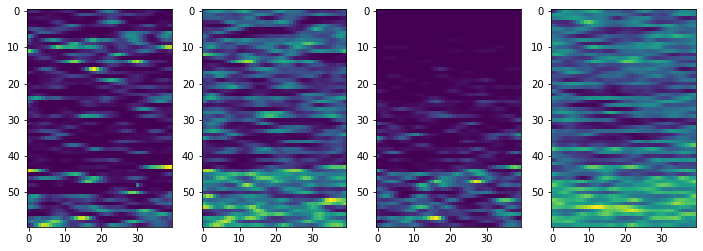

In [151]:
# maybe using template matching
# https://scikit-image.org/docs/stable/auto_examples/features_detection/plot_template.html

unit_names = ['7-18', '8-17', '8-13', '1-33']

fig = plt.figure(figsize=(12, 4))

vectors = []
for i, unit_name in enumerate(unit_names):
    with h5py.File(h5name, 'r') as f:
        i_rate = np.array(f['units'][unit_name][H5NAMES.inst_rate['name']])
        #i_rate = i_rate/i_rate.max()
    if unit_name == '7-18':
        i_rate[1930*s_rate:1950*s_rate] = 0
        
    i_rate_binned = i_rate[(100*np.linspace(0, 2399, 2400)).astype(np.int32)]
    i_rate_binned = (i_rate_binned - i_rate_binned.min()) / (i_rate_binned.max() - i_rate_binned.min())
    vectors.append(i_rate_binned)
    
vectors = np.array(vectors)
#vectors_norm = normalize(vectors)  # normalize with sklearn

for i, vector in enumerate(vectors):
    #vec = vector.copy()
    #vec[vector > 0.5]  = 1
    #vec[vector <= 0.5] = 0
    
    ax = fig.add_subplot(1, len(vectors), i+1)
    ax.imshow(vector.reshape((60, 40)))
    #print(vector.mean(), np.median(vector))